In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
from pydub import AudioSegment
from pydub.playback import play
from pythonosc import udp_client

### The AWS URL can be adjusted according to what data is being grabbed:

#### Year Data  
[This goes for years - 2023 right now (change the end to `/year.csv` for different years)](https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_year/2023.csv)  
**Link in plain text:**  
https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_year/2023.csv  

#### Station ID Data  
[This goes by specific stations - AGM00060403 right now (change the end to `/station_id.csv` for different years)](https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/AGM00060403.csv)  
**Link in plain text:**  
https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_station/AGM00060403.csv  

Here is a list of all of the NOAA stations:  
[NOAA Station List](https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt)


In [2]:
AWS_BASE_URL = "https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_year/"
AWS_STATION_LIST = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"

In [3]:
years = list(range(2000, 2024))  # 2000 to 2023
stations = ["USW00094728", "USW00023174", "USC00042319"]  # Example: NYC, LA, Texas

<b>Be warned that loading the data takes a while, just be patient<b>

In [4]:
def load_noaa_data(years, stations):
    dfs = []
    for year in years:
        url = f"{AWS_BASE_URL}{year}.csv"
        print(f"Fetching data for {year}...")
        response = requests.get(url)
        if response.status_code == 200:
            df = pd.read_csv(io.StringIO(response.text))
            df = df[df["ID"].isin(stations)]  # Filter for selected stations early
            df["Year"] = year  # Add Year column
            dfs.append(df)
        else:
            print(f"Failed to fetch data for {year}")
    return pd.concat(dfs, ignore_index=True) if dfs else None

df = load_noaa_data(years, stations)

Fetching data for 2000...
Fetching data for 2001...
Fetching data for 2002...
Fetching data for 2003...
Fetching data for 2004...
Fetching data for 2005...
Fetching data for 2006...
Fetching data for 2007...
Fetching data for 2008...
Fetching data for 2009...
Fetching data for 2010...
Fetching data for 2011...
Fetching data for 2012...
Fetching data for 2013...
Fetching data for 2014...
Fetching data for 2015...
Fetching data for 2016...
Fetching data for 2017...
Fetching data for 2018...
Fetching data for 2019...
Fetching data for 2020...
Fetching data for 2021...
Fetching data for 2022...
Fetching data for 2023...


In [18]:
df

,ID,DATE,ELEMENT,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,Year,TEMP_C
0,USW00094728,20000101,TMAX,100,NaN,NaN,0,2400.0,2000,10.0
1,USW00094728,20000101,TMIN,11,NaN,NaN,0,2400.0,2000,1.1
2,USW00094728,20000101,PRCP,0,NaN,NaN,0,2400.0,2000,0.0
8,USW00094728,20000101,TAVG,56,NaN,NaN,W,NaN,2000,5.6
16,USW00023174,20000101,TMAX,144,NaN,NaN,0,2400.0,2000,14.4
...,...,...,...,...,...,...,...,...,...,...
372839,USW00023174,20231231,PRCP,0,T,NaN,W,2400.0,2023,0.0
372848,USW00023174,20231231,TAVG,133,H,NaN,S,NaN,2023,13.3
372854,USC00042319,20231231,TMAX,161,NaN,NaN,W,2400.0,2023,16.1
372855,USC00042319,20231231,TMIN,50,NaN,NaN,W,2400.0,2023,5.0


In [19]:
df.to_csv('unprocessed_climate_data.csv', index=False)

In [5]:
# get and normalize the temperatures
df = df[df["ELEMENT"].isin(["TAVG", "PRCP", "TMAX", "TMIN"])]
df["TEMP_C"] = df["DATA_VALUE"] / 10

In [7]:
df_pivot = df.pivot_table(index=["ID", "Year"], columns="ELEMENT", values="TEMP_C", aggfunc="mean").reset_index()
df_pivot.columns = ["Station_ID", "Year", "Avg_Temp", "Precipitation", "Max_Temp", "Min_Temp"]

In [9]:
df_climate = df_pivot.groupby("Year").mean(numeric_only=True).reset_index()

In [10]:
df_climate["TEMP_NORM"] = (df_climate["Avg_Temp"] - df_climate["Avg_Temp"].min()) / (df_climate["Avg_Temp"].max() - df_climate["Avg_Temp"].min())

In [11]:
df_climate.head()

,Year,Avg_Temp,Precipitation,Max_Temp,Min_Temp,TEMP_NORM
0,2000,1.329690,14.785935,23.529004,12.762448,0.209954
1,2001,1.284658,15.010464,23.781356,13.266932,0.161055
2,2002,1.177443,15.069810,24.045132,13.060869,0.044634
3,2003,1.646119,14.731866,23.482257,13.177006,0.553554
4,2004,1.678051,15.104199,23.555033,13.269106,0.588228


In [12]:
df_climate.describe()

,Year,Avg_Temp,Precipitation,Max_Temp,Min_Temp,TEMP_NORM
count,24.000000,24.000000,17.000000,24.000000,24.000000,24.000000
mean,2011.500000,1.508496,16.723236,24.095400,13.771479,0.404114
std,7.071068,0.264472,1.529719,0.481200,0.551775,0.287182
min,2000.000000,1.136339,14.321698,23.482257,12.755251,0.000000
25%,2005.750000,1.278486,15.069810,23.638288,13.268563,0.154353
50%,2011.500000,1.506405,17.429041,24.046995,13.827534,0.401843
75%,2017.250000,1.704498,17.944384,24.571918,14.234890,0.616946
max,2023.000000,2.057260,18.500548,24.877260,14.556347,1.000000


In [13]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           24 non-null     int64  
 1   Avg_Temp       24 non-null     float64
 2   Precipitation  17 non-null     float64
 3   Max_Temp       24 non-null     float64
 4   Min_Temp       24 non-null     float64
 5   TEMP_NORM      24 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 1.3 KB


In [16]:
df_climate.to_csv('climate_data_processed.csv', index=False)

<Axes: >

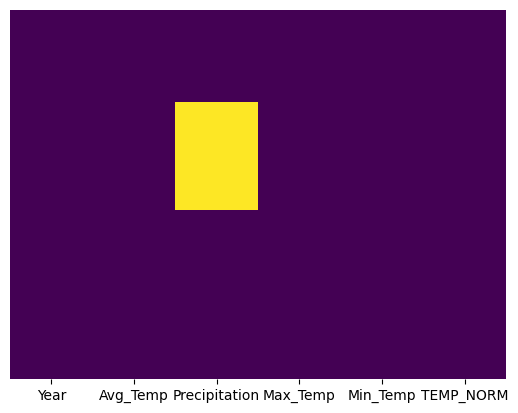

In [14]:
# null data heatmap
sns.heatmap(df_climate.isnull(), yticklabels=False, cbar=False, cmap="viridis")

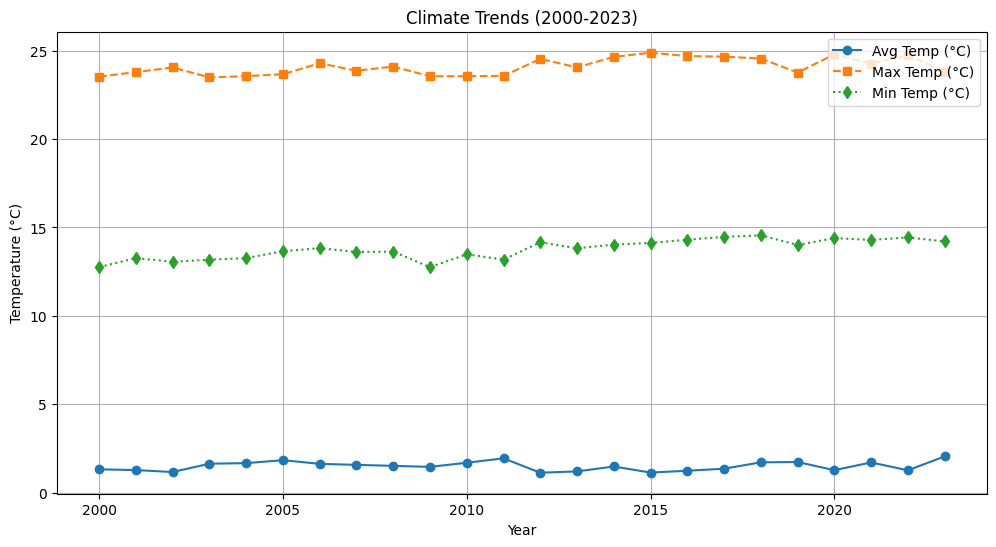

In [15]:
# graphing the climate trends
plt.figure(figsize=(12, 6))
plt.plot(df_climate["Year"], df_climate["Avg_Temp"], marker="o", linestyle="-", label="Avg Temp (°C)")
plt.plot(df_climate["Year"], df_climate["Max_Temp"], marker="s", linestyle="--", label="Max Temp (°C)")
plt.plot(df_climate["Year"], df_climate["Min_Temp"], marker="d", linestyle=":", label="Min Temp (°C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Climate Trends (2000-2023)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# load bird sounds
BIRD_SOUNDS = ["bird1.wav", "bird2.wav", "bird3.wav", "bird4.wav", "bird5.wav"]
bird_samples = [AudioSegment.from_wav(sound) for sound in BIRD_SOUNDS]

In [ ]:
def play_bird_sound(temp_value):
    index = int(temp_value * (len(bird_samples) - 1))  # map temperature to bird sound
    print(f"Playing bird sound {index} for temperature {temp_value:.2f}")
    play(bird_samples[index])

In [ ]:
first_temp = df_climate["TEMP_NORM"].iloc[0]
play_bird_sound(first_temp)

In [ ]:
client = udp_client.SimpleUDPClient("127.0.0.1", 7400)
client.send_message("/temperature", first_temp)